100%|██████████| 9.91M/9.91M [00:00<00:00, 39.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.12MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.0MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.12MB/s]


Epoch 1/10, Loss: 22.3021
Epoch 2/10, Loss: 8.9039
Epoch 3/10, Loss: 6.3416
Epoch 4/10, Loss: 5.2036
Epoch 5/10, Loss: 4.5116
Epoch 6/10, Loss: 3.9807
Epoch 7/10, Loss: 3.6081
Epoch 8/10, Loss: 3.3336
Epoch 9/10, Loss: 3.1120
Epoch 10/10, Loss: 2.9429
Silhouette Score: 0.0822
Davies-Bouldin Index: 2.4323


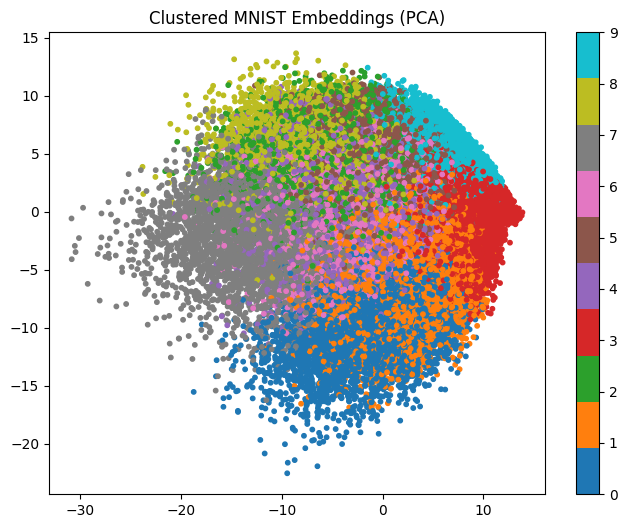

In [ ]:
# Install required libraries
!pip install torch torchvision scikit-learn matplotlib

# Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Set device (CPU)
device = torch.device('cpu')

# Load MNIST with torchvision
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # Flatten the 28x28 image to 784
])
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(mnist_train, batch_size=128, shuffle=True)

# Prepare full dataset as array
X_train = torch.cat([data for data, _ in train_loader]).numpy()

# Define Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=128, latent_dim=64):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

    def get_embedding(self, x):
        return self.encoder(x)

# Initialize model
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Train autoencoder
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        data = batch[0].to(device)
        output = model(data)
        loss = criterion(output, data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")

# Get embeddings
model.eval()
with torch.no_grad():
    embeddings = model.get_embedding(torch.Tensor(X_train).to(device)).cpu().numpy()

# KMeans clustering
kmeans = KMeans(n_clusters=10, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)

# Evaluation metrics
sil_score = silhouette_score(embeddings, cluster_labels)
db_score = davies_bouldin_score(embeddings, cluster_labels)
print(f"Silhouette Score: {sil_score:.4f}")
print(f"Davies-Bouldin Index: {db_score:.4f}")

# Visualize embeddings using PCA
pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)
plt.figure(figsize=(8,6))
plt.scatter(reduced[:, 0], reduced[:, 1], c=cluster_labels, cmap='tab10', s=10)
plt.title("Clustered MNIST Embeddings (PCA)")
plt.colorbar()
plt.show()
